In [1]:
# ============================================================
# CELL 1: IMPORTS
# ============================================================

# ============================================================
# CORE NUMERICAL & DATA HANDLING
# ============================================================
import numpy as np
import pandas as pd

# ============================================================
# VISUALIZATION
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# STATISTICAL TESTING
# ============================================================
from scipy import stats

# ============================================================
# SKLEARN: MODEL SELECTION & VALIDATION
# ============================================================
from sklearn.model_selection import (
    StratifiedKFold,
    train_test_split
)

# ============================================================
# SKLEARN: MODELS
# ============================================================
from sklearn.ensemble import RandomForestClassifier

# ============================================================
# SKLEARN: METRICS & FEATURE IMPORTANCE
# ============================================================
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    mutual_info_score
)
from sklearn.inspection import permutation_importance

# ============================================================
# GRADIENT BOOSTING
# ============================================================
import xgboost as xgb

# ============================================================
# RULE / ILP / STRUCTURAL UTILITIES
# ============================================================
import itertools
from collections import defaultdict
from dataclasses import dataclass
from typing import List, Dict, Tuple, Set

# ============================================================
# WARNINGS CONTROL
# ============================================================
import warnings
warnings.filterwarnings("ignore")

In [2]:
# ============================================================
# CELL 2: LOAD & INSPECT DATA
# ============================================================

# Load dataset
path = "/content/sample_data/bank-full.csv"
df = pd.read_csv(path, sep=";")

print(f"Shape: {df.shape}")
df.head()

Shape: (45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
# ============================================================
# CELL 3: CHECK INPUT TYPES
# ============================================================
print("📌 COLUMN SCHEMA\n" + "-"*60)
schema = pd.DataFrame({
    "column": df.columns,
    "dtype": df.dtypes.astype(str),
    "n_unique": [df[c].nunique() for c in df.columns]
})
schema

📌 COLUMN SCHEMA
------------------------------------------------------------


,column,dtype,n_unique
age,age,int64,77
job,job,object,12
marital,marital,object,3
education,education,object,4
default,default,object,2
balance,balance,int64,7168
housing,housing,object,2
loan,loan,object,2
contact,contact,object,3
day,day,int64,31


In [4]:
# ============================================================
# CELL 4: EXAMINE CATAGORICAL COLUMNS
# ============================================================

categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()

print("📌 CATEGORICAL COLUMNS\n" + "-"*60)
categorical_cols

for col in categorical_cols:
    print(f"\n🔎 Column: {col}")
    print("-" * 40)

    values = (
        df[col]
        .astype(str)
        .value_counts(dropna=False)
        .sort_index()
    )

    print(values)

📌 CATEGORICAL COLUMNS
------------------------------------------------------------

🔎 Column: job
----------------------------------------
job
admin.           5171
blue-collar      9732
entrepreneur     1487
housemaid        1240
management       9458
retired          2264
self-employed    1579
services         4154
student           938
technician       7597
unemployed       1303
unknown           288
Name: count, dtype: int64

🔎 Column: marital
----------------------------------------
marital
divorced     5207
married     27214
single      12790
Name: count, dtype: int64

🔎 Column: education
----------------------------------------
education
primary       6851
secondary    23202
tertiary     13301
unknown       1857
Name: count, dtype: int64

🔎 Column: default
----------------------------------------
default
no     44396
yes      815
Name: count, dtype: int64

🔎 Column: housing
----------------------------------------
housing
no     20081
yes    25130
Name: count, dtype: int64

🔎 Co

In [5]:
# ============================================================
# CELL 5: PREPROCESSING
# ============================================================

print("\n" + "="*80)
print("🔧 CLEAN PREPROCESSING")
print("="*80)

print(f"\nOriginal data shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# --------------------------------------------------
# 1. CREATE CLEAN df_proc FRAME
# --------------------------------------------------
print("\n" + "="*40)
print("1. CREATING CLEAN df_proc")
print("="*40)

df_proc = df.copy()

print(f"\nInitial shape: {df_proc.shape}")
print(f"Columns: {list(df_proc.columns)}")

# --------------------------------------------------
# 1.1 Target encoding
# --------------------------------------------------
print(f"\n🔍 Target column 'y' before conversion:")
print(df_proc['y'].value_counts())

df_proc['y'] = df_proc['y'].map({'yes': 1, 'no': 0})
assert df_proc['y'].notna().all(), "❌ Unexpected values in target y"
df_proc['y'] = df_proc['y'].astype('int8')

print(f"\n✅ Target 'y' converted:")
print(df_proc['y'].value_counts())

# --------------------------------------------------
# 1.2 Binary categorical encoding
# --------------------------------------------------
binary_cols = ['default', 'housing', 'loan']
binary_map = {'no': 0, 'yes': 1}

print(f"\n🔍 Binary columns before conversion:")
for col in binary_cols:
    print(f"{col}:\n{df_proc[col].value_counts()}")

for col in binary_cols:
    df_proc[col] = df_proc[col].map(binary_map)
    assert df_proc[col].notna().all(), f"❌ Unexpected values in {col}"
    df_proc[col] = df_proc[col].astype('int8')

print(f"\n✅ Binary columns converted:")
for col in binary_cols:
    print(f"{col}: {df_proc[col].unique()}")

# --------------------------------------------------
# 1.3 Month → ordinal (DROP RAW MONTH)
# --------------------------------------------------
print(f"\n🔍 Month column before conversion:")
print(df_proc['month'].value_counts().sort_index())

month_map = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
    'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
    'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}

df_proc['month_ordinal'] = df_proc['month'].map(month_map)
assert df_proc['month_ordinal'].notna().all(), "❌ Unexpected month values"
df_proc['month_ordinal'] = df_proc['month_ordinal'].astype('int8')

# DROP raw month (no objects allowed)
df_proc.drop(columns=['month'], inplace=True)

print(f"\n✅ Month converted to ordinal and raw month dropped")

# --------------------------------------------------
# 1.4 POUTCOME - EXPLICIT MAPPING
# --------------------------------------------------
print(f"\n🔍 poutcome column before conversion:")
print(df_proc['poutcome'].value_counts())

poutcome_map = {
    'unknown': 0,
    'failure': 1,
    'other': 2,
    'success': 3
}

df_proc['poutcome'] = df_proc['poutcome'].map(poutcome_map)
assert df_proc['poutcome'].notna().all(), "❌ Unexpected poutcome values"
df_proc['poutcome'] = df_proc['poutcome'].astype('int8')

print(f"\n✅ poutcome converted:")
print(df_proc['poutcome'].value_counts())

# --------------------------------------------------
# 1.5 CONTACT - ORDINAL MAPPING
# --------------------------------------------------
print(f"\n🔍 contact column before conversion:")
print(df_proc['contact'].value_counts())

# Map contact as ORDINAL: cellular=0, telephone=1, unknown=2
contact_map = {
    'cellular': 0,
    'telephone': 1,
    'unknown': 2
}

df_proc['contact'] = df_proc['contact'].map(contact_map)
assert df_proc['contact'].notna().all(), "❌ Unexpected contact values"
df_proc['contact'] = df_proc['contact'].astype('int8')

print(f"\n✅ contact converted to ordinal (0=cellular, 1=telephone, 2=unknown):")
print(df_proc['contact'].value_counts().sort_index())

# --------------------------------------------------
# 1.6 Ordinal / Label encoding REMAINING categoricals
# --------------------------------------------------
categorical_cols = df_proc.select_dtypes(include=['object']).columns.tolist()

print(f"\n🔍 Ordinal-encoding remaining categoricals:")
print(categorical_cols)

for col in categorical_cols:
    df_proc[col] = df_proc[col].astype('category').cat.codes
    df_proc[col] = df_proc[col].astype('int16')

# --------------------------------------------------
# 1.7 HARD TYPE GUARANTEE
# --------------------------------------------------
non_numeric = df_proc.select_dtypes(exclude=['number']).columns.tolist()
assert len(non_numeric) == 0, f"❌ NON-NUMERIC COLUMNS REMAIN: {non_numeric}"

print("\n✅ ALL COLUMNS ARE NUMERIC")

# --------------------------------------------------
# 1.8 Sanity checks
# --------------------------------------------------
print(f"\n📊 Data types in df_proc:")
for dtype in df_proc.dtypes.unique():
    cols = df_proc.columns[df_proc.dtypes == dtype].tolist()
    print(f"{dtype}: {cols}")

print(f"\n🔍 Checking for null values:")
assert df_proc.isnull().sum().sum() == 0, "❌ Nulls detected"
print("✅ No null values")

print(f"\n🔍 Checking for duplicates:")
dup_count = df_proc.duplicated().sum()
print(f"Exact duplicate rows: {dup_count} ({dup_count/len(df_proc)*100:.2f}%)")

# --------------------------------------------------
# 1.9 Final confirmation
# --------------------------------------------------
print(f"\n✅ df_proc created successfully!")
print(f"Shape: {df_proc.shape}")
print(f"Memory usage: {df_proc.memory_usage().sum() / 1024**2:.2f} MB")


🔧 CLEAN PREPROCESSING

Original data shape: (45211, 17)
Columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']

1. CREATING CLEAN df_proc

Initial shape: (45211, 17)
Columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']

🔍 Target column 'y' before conversion:
y
no     39922
yes     5289
Name: count, dtype: int64

✅ Target 'y' converted:
y
0    39922
1     5289
Name: count, dtype: int64

🔍 Binary columns before conversion:
default:
default
no     44396
yes      815
Name: count, dtype: int64
housing:
housing
yes    25130
no     20081
Name: count, dtype: int64
loan:
loan
no     37967
yes     7244
Name: count, dtype: int64

✅ Binary columns converted:
default: [0 1]
housing: [1 0]
loan: [0 1]

🔍 Month column before conversion:
month
apr     2932


In [9]:
!pip install interpret -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 34.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.1/780.1 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.7/264.7 kB 16.9 MB/s eta 0:00:00


🌳 CELL 11: EXPLAINABLE BOOSTING MACHINE (EBM) - FULL ANALYSIS

💻 INSTALL REQUIRED PACKAGE:
!pip install interpret -q

If already installed, continue with the analysis below.


🔧 11.1 DATA PREPARATION & 10-FOLD CROSS VALIDATION
--------------------------------------------------
Using df_proc with shape: (45211, 17)
Columns in df_proc: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y', 'month_ordinal']

Features (X) shape: (45211, 16)
Target (y) shape: (45211,)
Target distribution:
y
0    39922
1     5289
Name: count, dtype: int64
Positive class proportion: 0.117

✓ Train/Test Split:
  X_train: (36168, 16)
  y_train: (36168,) (positives: 4231 = 0.117)
  X_test: (9043, 16)
  y_test: (9043,) (positives: 1058 = 0.117)

✓ 10-fold Stratified Cross Validation configured

🤖 11.2 EBM MODEL TRAINING & CROSS-VALIDATION
--------------------------------------------------
✓ EBM model initializ

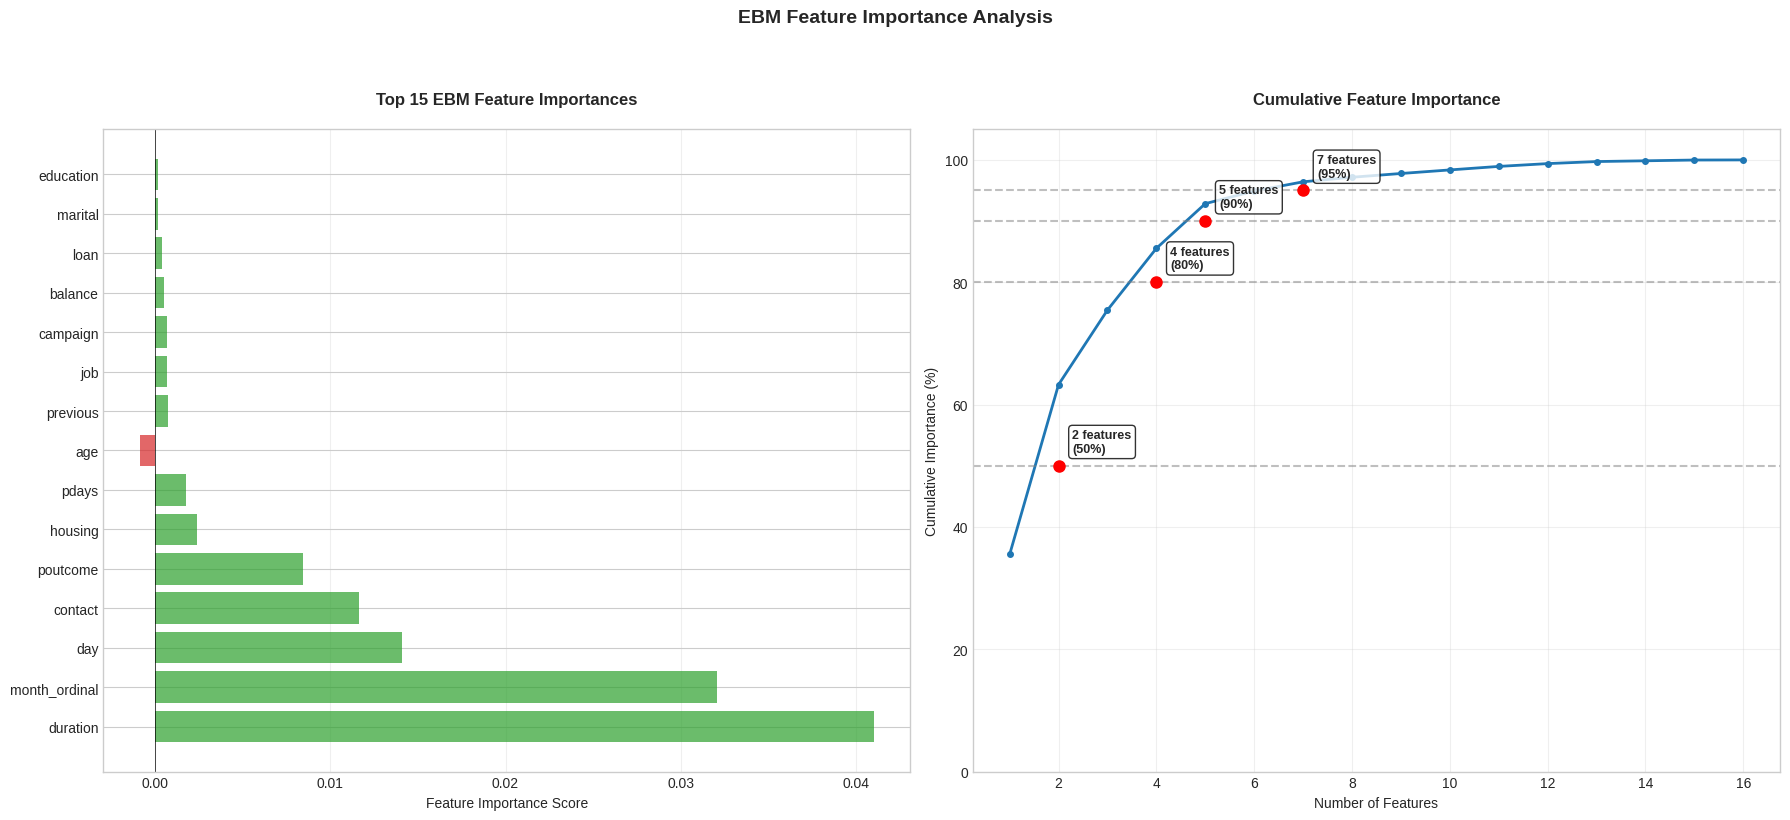


📈 11.4 EBM PARTIAL DEPENDENCE & INTERACTION ANALYSIS
--------------------------------------------------


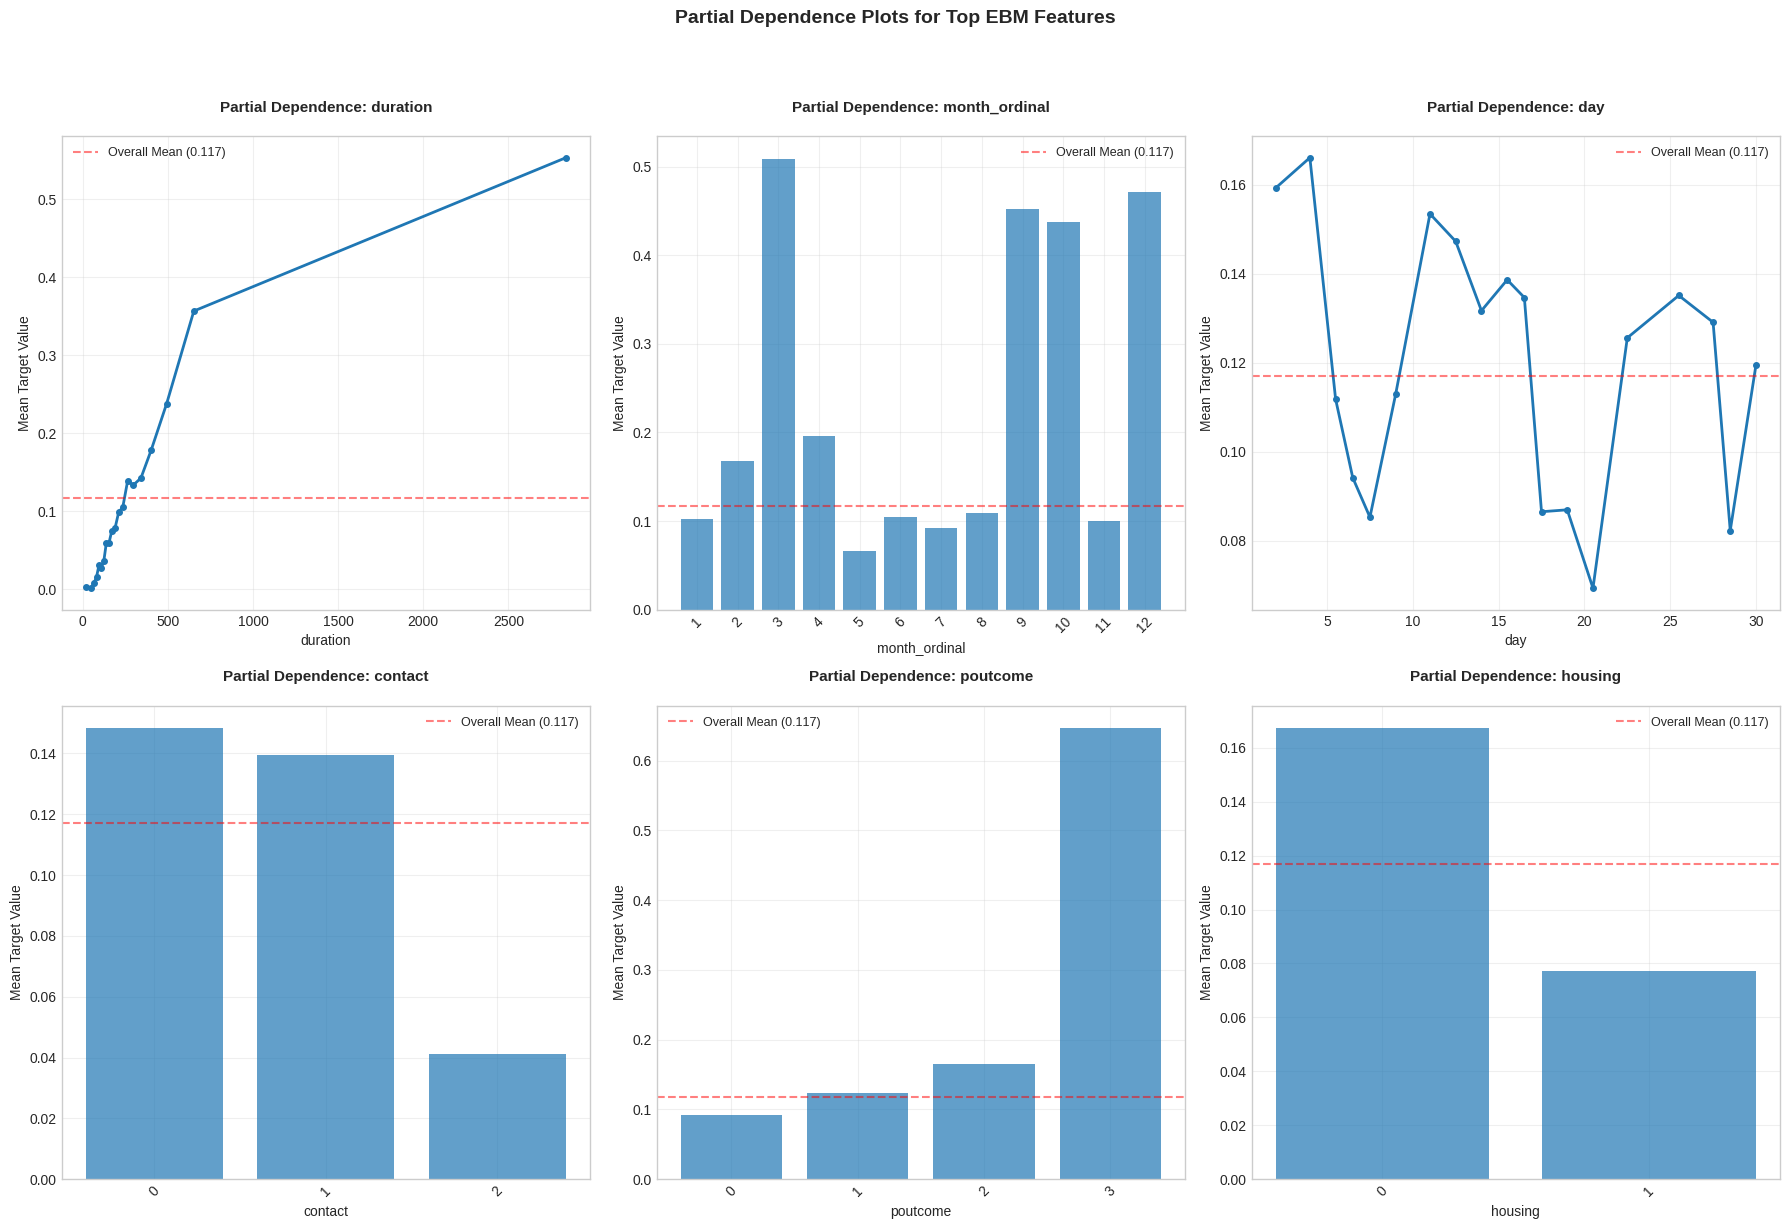


🔥 11.5 EBM INTERACTION ANALYSIS & HEATMAPS
--------------------------------------------------

🔍 Strongest Feature Interactions (Estimated):
  poutcome ↔ pdays: 1.000


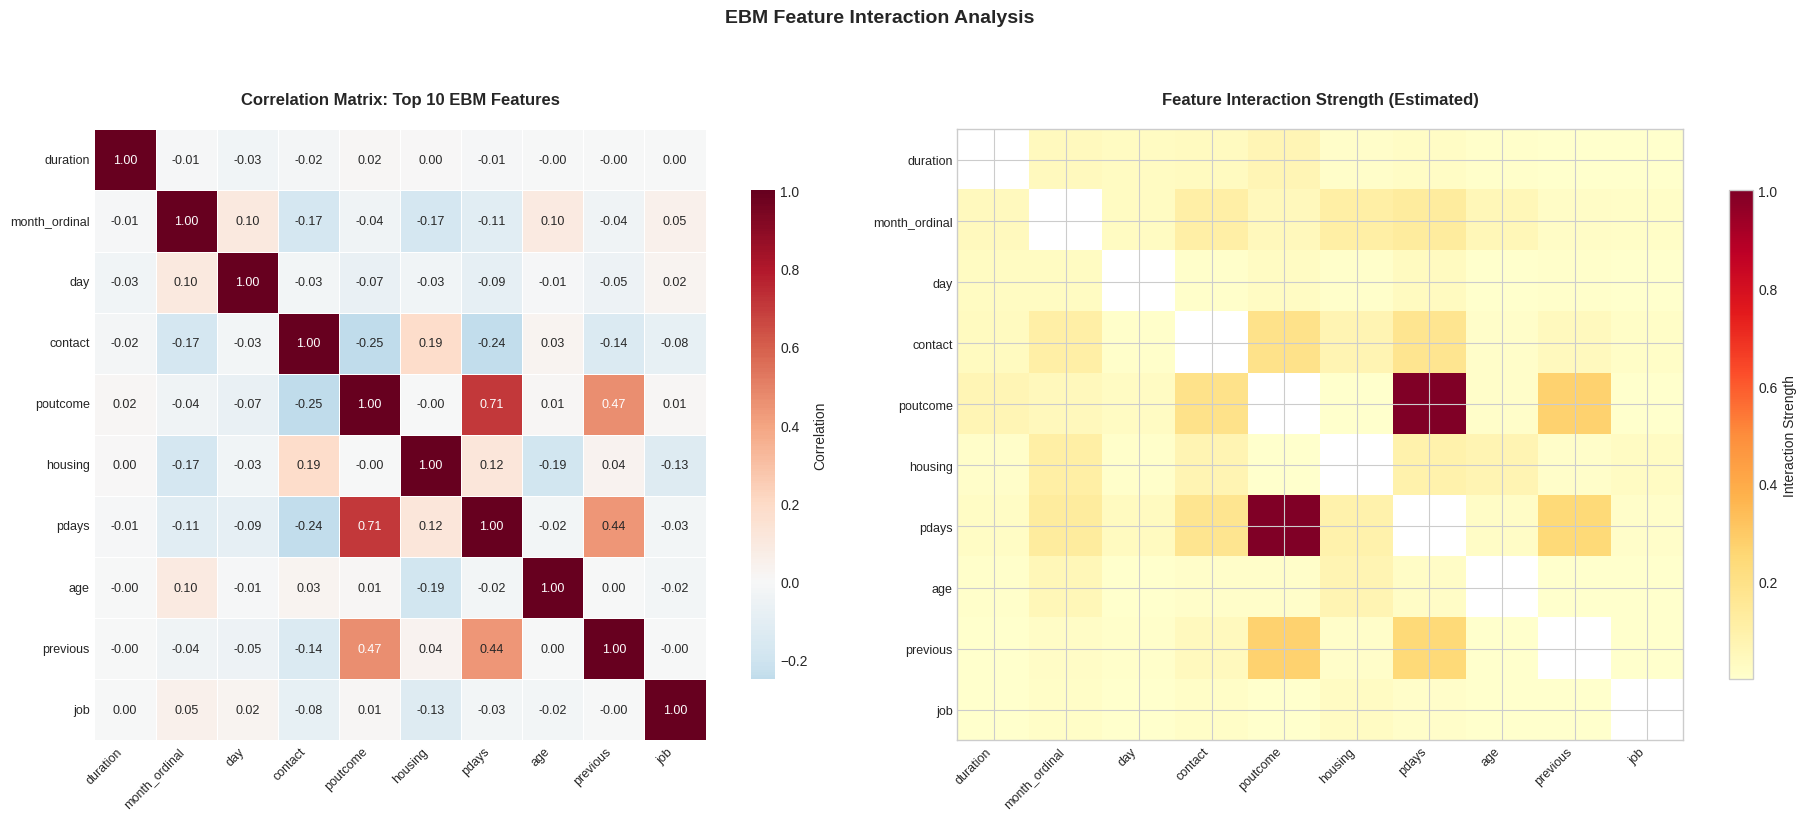


📊 11.6 EBM PREDICTION ANALYSIS & CALIBRATION
--------------------------------------------------


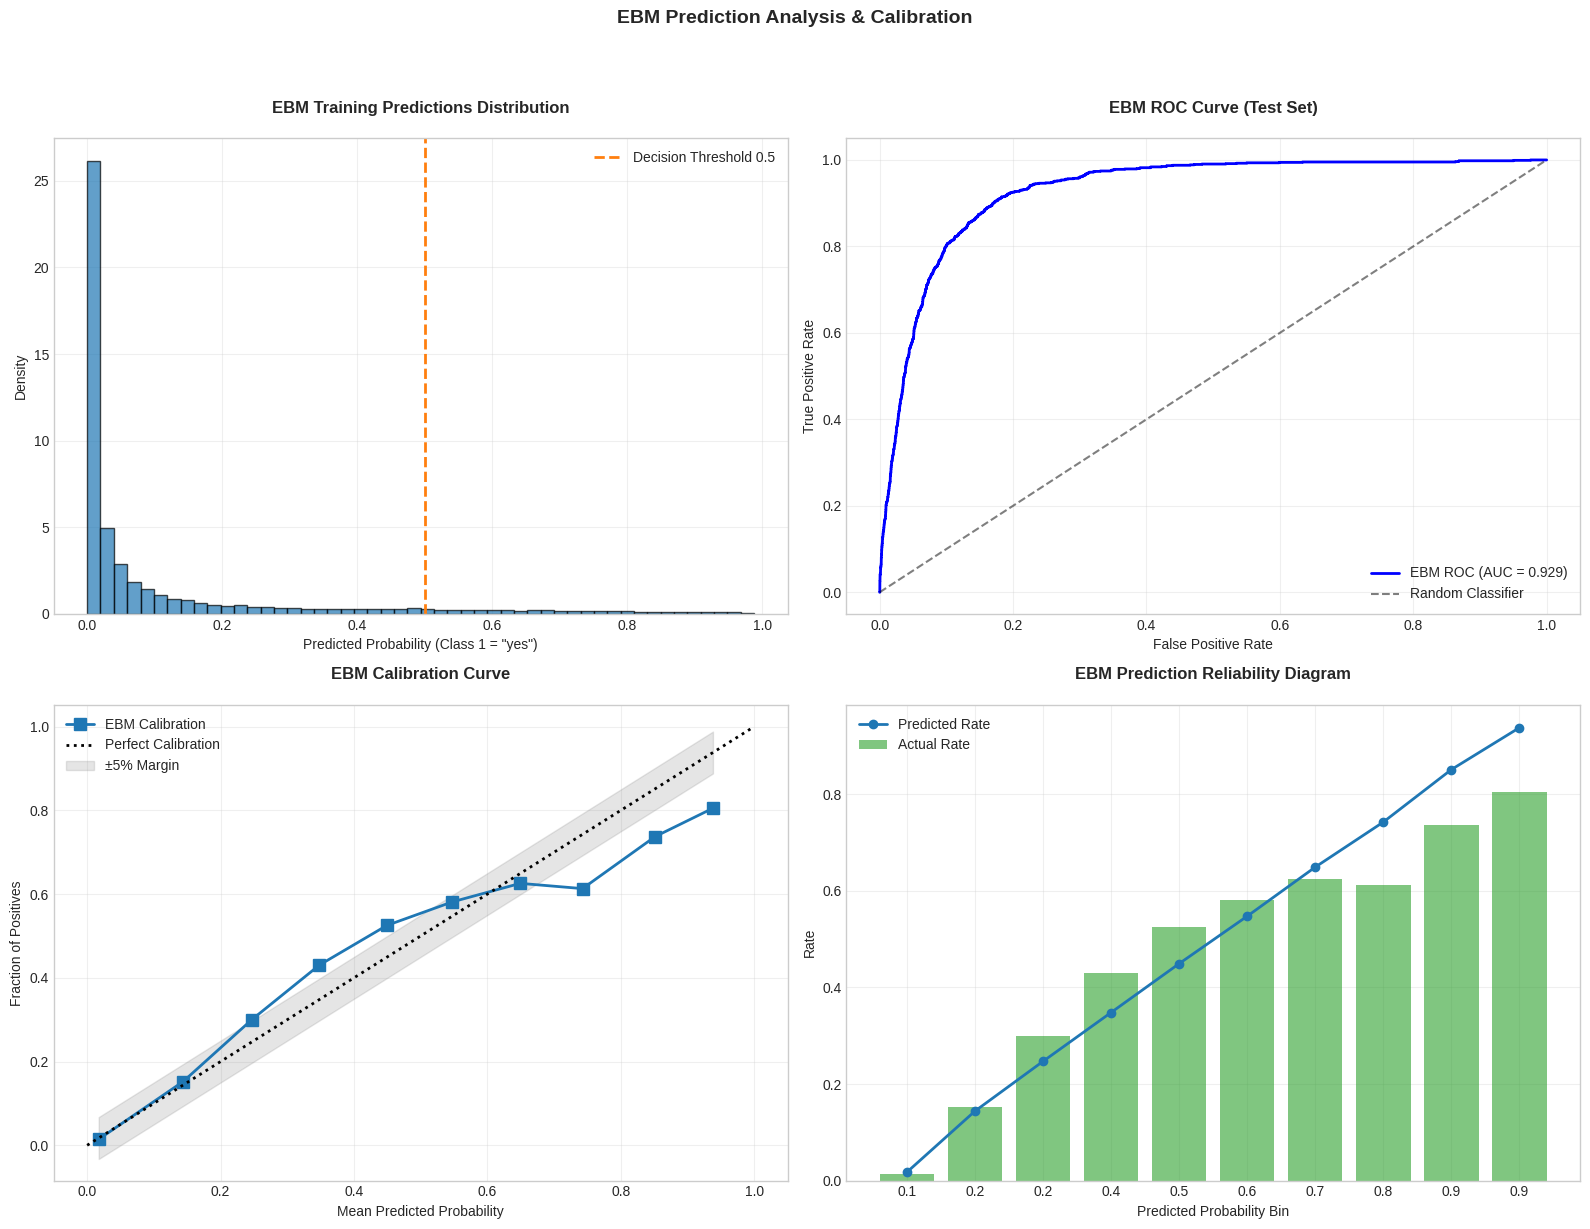


💾 11.7 EBM ENSEMBLE PREPARATION & MODEL PERSISTENCE
--------------------------------------------------
✅ EBM model saved to: ./models/ebm_model_20251220_223007.pkl
✅ EBM ensemble dictionary saved to: ./models/ebm_ensemble_dict_20251220_223007.pkl
✅ EBM ensemble dictionary saved (joblib) to: ./models/ebm_ensemble_joblib_20251220_223007.joblib

EXPLAINABLE BOOSTING MACHINE (EBM) - COMPREHENSIVE SUMMARY

MODEL INFORMATION:
Model Type: Explainable Boosting Machine
Training Date: 2025-12-20 22:30:07
Training Samples: 36168
Test Samples: 9043
Features: 16
Target Variable: 'y' (1 = 'yes', 0 = 'no')

CROSS-VALIDATION PERFORMANCE (10-fold):
Mean ROC-AUC: 0.9336
Std ROC-AUC: 0.0050
Min ROC-AUC: 0.9225
Max ROC-AUC: 0.9413

TEST SET PERFORMANCE:
Accuracy: 0.9071
Precision: 0.6461
Recall: 0.4556
F1-Score: 0.5344
ROC-AUC: 0.9291

TOP 10 FEATURES:
11. duration                  Importance: 0.0410
16. month_ordinal             Importance: 0.0321
10. day                       Importance: 0.0141
 9. con

In [11]:
# ============================================================
# CELL 11: EBM MODEL - COMPREHENSIVE ANALYSIS & ENSEMBLE PREP
# ============================================================
print("=" * 80)
print("🌳 CELL 11: EXPLAINABLE BOOSTING MACHINE (EBM) - FULL ANALYSIS")
print("=" * 80)

# INSTALLATION COMMAND - RUN THIS FIRST IF NEEDED
print("\n💻 INSTALL REQUIRED PACKAGE:")
print("!pip install interpret -q")
print("\nIf already installed, continue with the analysis below.\n")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pickle
import joblib
import os
import warnings
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, roc_curve, auc,
                           confusion_matrix, classification_report)
from sklearn.preprocessing import StandardScaler
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')

# Set consistent color scheme
COLOR_PALETTE = {
    'primary': '#1f77b4',      # Blue
    'secondary': '#ff7f0e',    # Orange
    'positive': '#2ca02c',     # Green
    'negative': '#d62728',     # Red
    'neutral': '#7f7f7f',      # Gray
    'highlight': '#9467bd',    # Purple
    'background': '#f0f0f0'
}

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette(sns.color_palette(list(COLOR_PALETTE.values())))

# --------------------------------------------------
# 11.1 DATA PREPARATION & 10-FOLD SETUP
# --------------------------------------------------
print("\n🔧 11.1 DATA PREPARATION & 10-FOLD CROSS VALIDATION")
print("-" * 50)

print(f"Using df_proc with shape: {df_proc.shape}")
print(f"Columns in df_proc: {list(df_proc.columns)}")

# Prepare features and target
X = df_proc.drop(columns=['y'])
y = df_proc['y']

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"Positive class proportion: {y.mean():.3f}")

# Split into train and test (holdout set)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✓ Train/Test Split:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape} (positives: {y_train.sum()} = {y_train.mean():.3f})")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape} (positives: {y_test.sum()} = {y_test.mean():.3f})")

# Setup 10-fold cross validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
print(f"\n✓ 10-fold Stratified Cross Validation configured")

# --------------------------------------------------
# 11.2 EBM MODEL TRAINING WITH CROSS-VALIDATION
# --------------------------------------------------
print("\n🤖 11.2 EBM MODEL TRAINING & CROSS-VALIDATION")
print("-" * 50)

# Initialize EBM model
ebm_model = ExplainableBoostingClassifier(
    random_state=42,
    max_bins=256,
    max_interaction_bins=32,
    interactions=10,
    learning_rate=0.01,
    validation_size=0.1,
    n_jobs=-1
)

print("✓ EBM model initialized with configuration:")
print(f"  • max_bins: 256")
print(f"  • interactions: 10")
print(f"  • learning_rate: 0.01")
print(f"  • validation_size: 0.1")

# Perform cross-validation
print("\n🔍 Performing 10-fold cross-validation...")
cv_scores = cross_val_score(
    ebm_model, X_train, y_train,
    cv=cv, scoring='roc_auc',
    n_jobs=-1
)

print(f"\n✓ Cross-validation complete!")
print(f"CV ROC-AUC scores: {cv_scores}")
print(f"Mean CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Train final model on full training data
print("\n🏋️ Training final EBM model on full training set...")
ebm_model.fit(X_train, y_train)

# Make predictions
y_pred_ebm = ebm_model.predict(X_test)
y_pred_proba_ebm = ebm_model.predict_proba(X_test)[:, 1]

# Calculate comprehensive metrics
metrics_ebm = {
    'Accuracy': accuracy_score(y_test, y_pred_ebm),
    'Precision': precision_score(y_test, y_pred_ebm, average='binary'),
    'Recall': recall_score(y_test, y_pred_ebm, average='binary'),
    'F1-Score': f1_score(y_test, y_pred_ebm, average='binary'),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_ebm),
    'CV_ROC_AUC_mean': cv_scores.mean(),
    'CV_ROC_AUC_std': cv_scores.std()
}

print("\n✅ EBM Model Performance Summary:")
print("="*60)
for metric, value in metrics_ebm.items():
    if 'CV' not in metric:
        print(f"{metric}: {value:.4f}")

print(f"\nCross-Validation Performance:")
print(f"Mean ROC-AUC: {cv_scores.mean():.4f}")
print(f"Std ROC-AUC: {cv_scores.std():.4f}")
print(f"Range: [{cv_scores.min():.4f}, {cv_scores.max():.4f}]")

# --------------------------------------------------
# 11.3 EBM FEATURE IMPORTANCE & GLOBAL EXPLANATIONS
# --------------------------------------------------
print("\n📊 11.3 EBM FEATURE IMPORTANCE & GLOBAL EXPLANATIONS")
print("-" * 50)

# Get feature importance from EBM
try:
    importance_scores = ebm_model.feature_importances_
except:
    # Fallback to permutation importance if standard importances not available
    from sklearn.inspection import permutation_importance
    perm_importance = permutation_importance(ebm_model, X_test, y_test,
                                           n_repeats=10, random_state=42)
    importance_scores = perm_importance.importances_mean

feature_importance_ebm = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance_scores,
    'Abs_Importance': np.abs(importance_scores)
}).sort_values('Abs_Importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance_ebm.head(15).to_string(index=False))

# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Bar plot of feature importance
top_n = 15
top_features_ebm = feature_importance_ebm.head(top_n)

bars = axes[0].barh(range(len(top_features_ebm)),
                   top_features_ebm['Importance'].values,
                   color=[COLOR_PALETTE['positive'] if x > 0 else COLOR_PALETTE['negative']
                          for x in top_features_ebm['Importance'].values],
                   alpha=0.7)
axes[0].set_yticks(range(len(top_features_ebm)))
axes[0].set_yticklabels(top_features_ebm['Feature'].values)
axes[0].set_xlabel('Feature Importance Score')
axes[0].set_title(f'Top {top_n} EBM Feature Importances\n',
                  fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].axvline(x=0, color='black', linewidth=0.5)

# Cumulative importance plot
cumulative_importance = np.cumsum(feature_importance_ebm['Abs_Importance'].values)
cumulative_importance = cumulative_importance / cumulative_importance[-1]

axes[1].plot(range(1, len(cumulative_importance) + 1),
            cumulative_importance * 100,
            'o-',
            color=COLOR_PALETTE['primary'],
            linewidth=2,
            markersize=4)

# Add markers for key points
for threshold in [0.5, 0.8, 0.9, 0.95]:
    idx = np.where(cumulative_importance >= threshold)[0]
    if len(idx) > 0:
        n_features = idx[0] + 1
        axes[1].axhline(y=threshold * 100, color='gray', linestyle='--', alpha=0.5)
        axes[1].plot(n_features, threshold * 100, 'ro', markersize=8)
        axes[1].annotate(f'{n_features} features\n({threshold*100:.0f}%)',
                        (n_features, threshold * 100),
                        xytext=(10, 10), textcoords='offset points',
                        fontsize=9, fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

axes[1].set_xlabel('Number of Features')
axes[1].set_ylabel('Cumulative Importance (%)')
axes[1].set_title('Cumulative Feature Importance\n',
                  fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 105])

plt.suptitle('EBM Feature Importance Analysis\n',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 11.4 EBM PARTIAL DEPENDENCE & SHAP ANALYSIS
# --------------------------------------------------
print("\n📈 11.4 EBM PARTIAL DEPENDENCE & INTERACTION ANALYSIS")
print("-" * 50)

# Select top 6 features for detailed analysis
top_6_features = feature_importance_ebm.head(6)['Feature'].values

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for idx, (ax, feature) in enumerate(zip(axes.flat, top_6_features)):
    # Create bins for the feature
    unique_vals = X_train[feature].unique()

    if len(unique_vals) <= 20:
        # For categorical/low-cardinality features
        mean_response_by_value = []
        for val in sorted(unique_vals):
            mask = X_train[feature] == val
            if mask.sum() > 0:
                mean_response = y_train[mask].mean()
                mean_response_by_value.append((val, mean_response))

        if mean_response_by_value:
            vals, means = zip(*mean_response_by_value)
            bars = ax.bar(range(len(vals)), means,
                         color=COLOR_PALETTE['primary'], alpha=0.7)
            ax.set_xticks(range(len(vals)))
            ax.set_xticklabels([str(v) for v in vals], rotation=45)

    else:
        # For continuous features - create bins
        bins = np.percentile(X_train[feature], np.linspace(0, 100, 21))
        bin_centers = (bins[:-1] + bins[1:]) / 2
        bin_indices = np.digitize(X_train[feature], bins) - 1

        mean_response_by_bin = []
        for i in range(len(bins)-1):
            mask = bin_indices == i
            if mask.sum() > 0:
                mean_response = y_train[mask].mean()
                mean_response_by_bin.append((bin_centers[i], mean_response))

        if mean_response_by_bin:
            centers, means = zip(*mean_response_by_bin)
            ax.plot(centers, means, 'o-',
                   color=COLOR_PALETTE['primary'],
                   linewidth=2,
                   markersize=4)

    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel('Mean Target Value', fontsize=10)
    ax.set_title(f'Partial Dependence: {feature}\n', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=y_train.mean(), color='red', linestyle='--', alpha=0.5,
               label=f'Overall Mean ({y_train.mean():.3f})')
    ax.legend(loc='best', fontsize=9)

plt.suptitle('Partial Dependence Plots for Top EBM Features\n',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 11.5 EBM INTERACTION HEATMAP & PAIRWISE ANALYSIS
# --------------------------------------------------
print("\n🔥 11.5 EBM INTERACTION ANALYSIS & HEATMAPS")
print("-" * 50)

# Calculate correlation matrix for top features
top_10_features = feature_importance_ebm.head(10)['Feature'].values
correlation_matrix_top = X_train[top_10_features].corr()

# Create interaction analysis
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Heatmap 1: Correlation matrix
sns.heatmap(correlation_matrix_top,
            cmap='RdBu_r',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8, "label": "Correlation"},
            annot=True,
            fmt='.2f',
            annot_kws={'size': 9},
            ax=axes[0])

axes[0].set_title('Correlation Matrix: Top 10 EBM Features\n',
                  fontsize=12, fontweight='bold')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right', fontsize=9)
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0, fontsize=9)

# Create interaction strength visualization
interaction_matrix = np.zeros((len(top_10_features), len(top_10_features)))

# Calculate mutual information for each feature with target
mi_scores = mutual_info_classif(X_train[top_10_features], y_train, random_state=42)
mi_df = pd.DataFrame({'Feature': top_10_features, 'MI_Score': mi_scores})

# Create interaction matrix (simplified - could be enhanced with actual EBM interaction scores)
for i, feat1 in enumerate(top_10_features):
    for j, feat2 in enumerate(top_10_features):
        if i != j:
            # Simple interaction measure: product of individual MI scores * correlation
            corr = np.abs(correlation_matrix_top.iloc[i, j])
            interaction_matrix[i, j] = mi_df.iloc[i]['MI_Score'] * mi_df.iloc[j]['MI_Score'] * corr

# Normalize
if interaction_matrix.max() > 0:
    interaction_matrix = interaction_matrix / interaction_matrix.max()

# Mask diagonal
mask = np.eye(len(top_10_features), dtype=bool)
interaction_matrix_masked = np.ma.array(interaction_matrix, mask=mask)

# Heatmap 2: Interaction strength
im = axes[1].imshow(interaction_matrix_masked, cmap='YlOrRd', aspect='auto')
axes[1].set_xticks(range(len(top_10_features)))
axes[1].set_yticks(range(len(top_10_features)))
axes[1].set_xticklabels(top_10_features, rotation=45, ha='right', fontsize=9)
axes[1].set_yticklabels(top_10_features, fontsize=9)
axes[1].set_title('Feature Interaction Strength (Estimated)\n',
                  fontsize=12, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=axes[1], shrink=0.8)
cbar.set_label('Interaction Strength', fontsize=10)

# Annotate strongest interactions
strong_interactions = []
for i in range(len(top_10_features)):
    for j in range(i+1, len(top_10_features)):
        if interaction_matrix[i, j] > 0.5:  # Threshold for strong interaction
            strong_interactions.append((top_10_features[i], top_10_features[j], interaction_matrix[i, j]))

if strong_interactions:
    print("\n🔍 Strongest Feature Interactions (Estimated):")
    for feat1, feat2, strength in sorted(strong_interactions, key=lambda x: x[2], reverse=True)[:5]:
        print(f"  {feat1} ↔ {feat2}: {strength:.3f}")

plt.suptitle('EBM Feature Interaction Analysis\n',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 11.6 EBM PREDICTION DISTRIBUTION & CALIBRATION
# --------------------------------------------------
print("\n📊 11.6 EBM PREDICTION ANALYSIS & CALIBRATION")
print("-" * 50)

# Get training predictions for ensemble
ebm_X_train = ebm_model.predict_proba(X_train)[:, 1]
ebm_X_test = ebm_model.predict_proba(X_test)[:, 1]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution of predicted probabilities
axes[0, 0].hist(ebm_X_train, bins=50, alpha=0.7,
                color=COLOR_PALETTE['primary'], edgecolor='black', density=True)
axes[0, 0].axvline(x=0.5, color=COLOR_PALETTE['secondary'],
                   linestyle='--', linewidth=2, label='Decision Threshold 0.5')
axes[0, 0].set_xlabel('Predicted Probability (Class 1 = "yes")')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('EBM Training Predictions Distribution\n',
                     fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. ROC Curve
fpr_ebm, tpr_ebm, _ = roc_curve(y_test, y_pred_proba_ebm)
roc_auc_ebm = auc(fpr_ebm, tpr_ebm)

axes[0, 1].plot(fpr_ebm, tpr_ebm, 'b-',
                label=f'EBM ROC (AUC = {roc_auc_ebm:.3f})',
                linewidth=2)
axes[0, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('EBM ROC Curve (Test Set)\n',
                     fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Calibration curve
from sklearn.calibration import calibration_curve

prob_true_ebm, prob_pred_ebm = calibration_curve(y_test, y_pred_proba_ebm, n_bins=10)

axes[1, 0].plot(prob_pred_ebm, prob_true_ebm, 's-',
                color=COLOR_PALETTE['primary'],
                linewidth=2,
                markersize=8,
                label='EBM Calibration')
axes[1, 0].plot([0, 1], [0, 1], 'k:',
                label='Perfect Calibration',
                linewidth=2)
axes[1, 0].fill_between(prob_pred_ebm,
                        prob_pred_ebm - 0.05,
                        prob_pred_ebm + 0.05,
                        alpha=0.2,
                        color=COLOR_PALETTE['neutral'],
                        label='±5% Margin')

axes[1, 0].set_xlabel('Mean Predicted Probability')
axes[1, 0].set_ylabel('Fraction of Positives')
axes[1, 0].set_title('EBM Calibration Curve\n',
                     fontsize=12, fontweight='bold')
axes[1, 0].legend(loc='upper left')
axes[1, 0].grid(True, alpha=0.3)

# 4. Prediction reliability diagram
pred_bins = np.linspace(0, 1, 11)
bin_centers = (pred_bins[:-1] + pred_bins[1:]) / 2
bin_indices = np.digitize(ebm_X_test, pred_bins) - 1

actual_rates = []
pred_rates = []
for i in range(len(pred_bins)-1):
    mask = bin_indices == i
    if mask.sum() > 0:
        actual_rates.append(y_test[mask].mean())
        pred_rates.append(ebm_X_test[mask].mean())
    else:
        actual_rates.append(np.nan)
        pred_rates.append(np.nan)

axes[1, 1].bar(bin_centers, actual_rates, width=0.08,
               color=COLOR_PALETTE['positive'], alpha=0.6,
               label='Actual Rate')
axes[1, 1].plot(bin_centers, pred_rates, 'o-',
                color=COLOR_PALETTE['primary'],
                linewidth=2,
                markersize=6,
                label='Predicted Rate')
axes[1, 1].set_xlabel('Predicted Probability Bin')
axes[1, 1].set_ylabel('Rate')
axes[1, 1].set_title('EBM Prediction Reliability Diagram\n',
                     fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(bin_centers)
axes[1, 1].set_xticklabels([f'{c:.1f}' for c in bin_centers])

plt.suptitle('EBM Prediction Analysis & Calibration\n',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 11.7 EBM ENSEMBLE PREPARATION & MODEL PERSISTENCE
# --------------------------------------------------
print("\n💾 11.7 EBM ENSEMBLE PREPARATION & MODEL PERSISTENCE")
print("-" * 50)

# Create comprehensive ensemble dictionary
ebm_ensemble_dict = {
    'model': ebm_model,
    'model_name': 'explainable_boosting_machine',
    'model_type': 'EBM',
    'feature_names': X.columns.tolist(),
    'training_data_shape': X_train.shape,
    'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),

    # Cross-validation results
    'cv_scores': cv_scores.tolist(),
    'cv_mean': cv_scores.mean(),
    'cv_std': cv_scores.std(),

    # Performance metrics
    'performance_metrics': metrics_ebm,

    # Feature importance
    'feature_importance': feature_importance_ebm.to_dict(),
    'top_features': feature_importance_ebm.head(20)['Feature'].tolist(),

    # Predictions for ensemble stacking
    'train_predictions': ebm_X_train,
    'test_predictions': ebm_X_test,
    'train_labels': y_train.values,
    'test_labels': y_test.values,

    # Model configuration
    'model_params': ebm_model.get_params(),

    # Data info
    'target_distribution': dict(y.value_counts()),
    'target_proportion': y.mean()
}

# Save model and ensemble dictionary
base_path = "./models"
os.makedirs(base_path, exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
ebm_model_filename = f"{base_path}/ebm_model_{timestamp}.pkl"
ebm_ensemble_filename = f"{base_path}/ebm_ensemble_dict_{timestamp}.pkl"
ebm_joblib_filename = f"{base_path}/ebm_ensemble_joblib_{timestamp}.joblib"

# Save using pickle
with open(ebm_model_filename, 'wb') as f:
    pickle.dump(ebm_model, f)
print(f"✅ EBM model saved to: {ebm_model_filename}")

with open(ebm_ensemble_filename, 'wb') as f:
    pickle.dump(ebm_ensemble_dict, f)
print(f"✅ EBM ensemble dictionary saved to: {ebm_ensemble_filename}")

# Save using joblib
joblib.dump(ebm_ensemble_dict, ebm_joblib_filename)
print(f"✅ EBM ensemble dictionary saved (joblib) to: {ebm_joblib_filename}")

# Create comprehensive summary report
summary_report_ebm = f"""
{'='*70}
EXPLAINABLE BOOSTING MACHINE (EBM) - COMPREHENSIVE SUMMARY
{'='*70}

MODEL INFORMATION:
Model Type: Explainable Boosting Machine
Training Date: {ebm_ensemble_dict['training_date']}
Training Samples: {X_train.shape[0]}
Test Samples: {X_test.shape[0]}
Features: {X_train.shape[1]}
Target Variable: 'y' (1 = 'yes', 0 = 'no')

CROSS-VALIDATION PERFORMANCE (10-fold):
Mean ROC-AUC: {cv_scores.mean():.4f}
Std ROC-AUC: {cv_scores.std():.4f}
Min ROC-AUC: {cv_scores.min():.4f}
Max ROC-AUC: {cv_scores.max():.4f}

TEST SET PERFORMANCE:
Accuracy: {metrics_ebm['Accuracy']:.4f}
Precision: {metrics_ebm['Precision']:.4f}
Recall: {metrics_ebm['Recall']:.4f}
F1-Score: {metrics_ebm['F1-Score']:.4f}
ROC-AUC: {metrics_ebm['ROC-AUC']:.4f}

TOP 10 FEATURES:
"""
for i, row in feature_importance_ebm.head(10).iterrows():
    summary_report_ebm += f"{i+1:2}. {row['Feature']:25} Importance: {row['Importance']:.4f}\n"

summary_report_ebm += f"""
DATA CHARACTERISTICS:
Positive Class Proportion: {y.mean():.3f}
Training Set Positives: {y_train.sum()} ({y_train.mean():.3f})
Test Set Positives: {y_test.sum()} ({y_test.mean():.3f})

ENSEMBLE READY OUTPUTS:
Training Predictions Shape: {ebm_X_train.shape}
Test Predictions Shape: {ebm_X_test.shape}
Available for Meta-Ensemble: ✓ YES

SAVED FILES:
Model file: {ebm_model_filename}
Ensemble dict: {ebm_ensemble_filename}
Joblib file: {ebm_joblib_filename}

ENSEMBLE INTEGRATION:
- Use 'ebm_X_train' as features for meta-learner
- Shape: {ebm_X_train.shape}
- Range: [{ebm_X_train.min():.4f}, {ebm_X_train.max():.4f}]
- Mean: {ebm_X_train.mean():.4f}
{'='*70}
"""

print(summary_report_ebm)

# Save summary to file
summary_filename_ebm = f"{base_path}/ebm_model_summary_{timestamp}.txt"
with open(summary_filename_ebm, 'w') as f:
    f.write(summary_report_ebm)
print(f"✅ EBM summary report saved to: {summary_filename_ebm}")

# --------------------------------------------------
# 11.8 EBM ENSEMBLE READINESS & NEXT STEPS
# --------------------------------------------------
print("\n🎯 11.8 EBM ENSEMBLE INTEGRATION READINESS")
print("-" * 50)

print(f"\n✅ EBM Model Successfully Prepared for Ensemble Stacking!")
print(f"\n📊 Key Outputs for Meta-Ensemble:")
print(f"1. Training Predictions: ebm_X_train")
print(f"   • Shape: {ebm_X_train.shape}")
print(f"   • Type: {type(ebm_X_train)}")
print(f"   • Range: [{ebm_X_train.min():.4f}, {ebm_X_train.max():.4f}]")
print(f"   • Mean: {ebm_X_train.mean():.4f}")

print(f"\n2. Test Predictions: ebm_X_test")
print(f"   • Shape: {ebm_X_test.shape}")
print(f"   • Available for validation")

print(f"\n3. Feature Importances:")
print(f"   • Top feature: {feature_importance_ebm.iloc[0]['Feature']}")
print(f"   • Importance score: {feature_importance_ebm.iloc[0]['Importance']:.4f}")

print(f"\n4. Cross-Validation Reliability:")
print(f"   • Mean CV ROC-AUC: {cv_scores.mean():.4f}")
print(f"   • CV Std: {cv_scores.std():.4f}")
print(f"   • Fold consistency: {'✓ HIGH' if cv_scores.std() < 0.05 else '○ MODERATE'}")

print(f"\n💡 ENSEMBLE STRATEGY RECOMMENDATIONS:")
print("1. EBM captures non-linear relationships and interactions")
print("2. Use EBM predictions as robust meta-features")
print("3. Combine with other models (like logistic regression) for diversity")
print("4. Consider feature interactions identified by EBM")

print(f"\n📁 All files saved in: {base_path}/")
print(f"   • Model: {ebm_model_filename}")
print(f"   • Ensemble dict: {ebm_ensemble_filename}")
print(f"   • Summary: {summary_filename_ebm}")

print(f"\n✅ EBM ANALYSIS COMPLETE - READY FOR META-ENSEMBLE CONSTRUCTION!")

# Final check: verify predictions are saved correctly
print("\n🔍 Final Verification:")
print(f"ebm_X_train loaded: {len(ebm_X_train)} predictions")
print(f"ebm_X_test loaded: {len(ebm_X_test)} predictions")
print(f"Model saved and ready for ensemble stacking!")

In [ ]:
# TODO: Refactor and clean the notebook to ensure consistent, correct usage of all dataframes.
# TODO: Identify and remove redundant or weakly informative features in the feature set.
# TODO: Engineer curvature-, clustering-, or geometry-inspired features that capture
#       subscriber lifecycle dynamics and behavioral transitions.
# TODO: Enforce interpretability constraints: all engineered features must be intuitive,
#       explainable, and aligned with GLASS-BRW glass-box principles (no opaque complexity).
